In [1]:
import torch
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# GPU Basics

In [2]:
!nvidia-smi

Fri Jul 19 11:00:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:C8:00.0 Off |                    0 |
| N/A   30C    P0    91W / 400W |      2MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Tensors are created on the CPU by default
A = torch.zeros(1000)
print(A.device)

# Move a CPU tensor to the GPU
B = A.cuda()
C = A.to(device='cuda')  # cuda or cuda:0 to specify a particular GPU if you have many
print(B.device, C.device)

# Can also create tensors directly on the GPU (more efficient)
D = torch.zeros(1000, device='cuda:0')
print(D.device)

cpu
cuda:0 cuda:0
cuda:0


# Floating Point Numbers and Formats
Some of this may only be supported on newer GPUs like A100

In [4]:
# By default tensors are created in either float32 or int64
A = torch.zeros(1000, device='cuda')
print(A.dtype)

B = torch.arange(1000, device='cuda')
print(B.dtype)

C = torch.randn(1000, device='cuda')
print(C.dtype)


torch.float32
torch.int64
torch.float32


In [5]:
# We can specify the dtype on creation
A = torch.zeros(1000, device='cuda', dtype=torch.float16)
print(A.dtype)

# We can also cast a tensor from one format to another
B = A.to(torch.bfloat16)
print(B.dtype)

# NOTE: CPUs have poor support for other formats, can store them but sometimes not perform operations
# Many types: bool, uint8, int8, int16, int32, int64, bfloat16, float16, float32, float64, complex formats...

torch.float16
torch.bfloat16


In [6]:
# Numerical Issues

# Accuracy
A = torch.full((1,), 257.0, dtype=torch.bfloat16)
B = torch.tensor([1.234567], dtype=torch.bfloat16)
print(A, B)  # These values can not be represented perfectly

# Exponent Range
A = torch.tensor([1e5], dtype=torch.float16)
print(A)  # Value is too high, can not be represented in float16 (replaced by infinity)
B = torch.tensor([1e-8], dtype=torch.float16)
print(B)  # Value is too low, replaced by zero

# Swamping
A = torch.tensor([1], dtype=torch.bfloat16)
B = torch.tensor([0], dtype=torch.bfloat16)

for i in range(500):
    B += A
print(B)  # Eventually the change in B is too small to be represented and it stops increasing

A = torch.ones(500, dtype=torch.bfloat16)
print(A.sum())  # Internally this operation may be performed in higher precision or using tree-like reductions that can help with swamping

tensor([256.], dtype=torch.bfloat16) tensor([1.2344], dtype=torch.bfloat16)
tensor([inf], dtype=torch.float16)
tensor([0.], dtype=torch.float16)
tensor([256.], dtype=torch.bfloat16)
tensor(500., dtype=torch.bfloat16)


# Performance

In [7]:
# Function to measure the time required to perform a function on GPU
def measure_performance(func, *args, repeats=16, **kwargs):
    times = []
    torch.cuda.synchronize()
    for _ in range(repeats):
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        
        start.record()
        result = func(*args, **kwargs)
        end.record()
        
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end) / 1000)  # Convert to seconds
    
    return result, sum(times) / len(times)  # Return average time

device = torch.device("cuda:0")

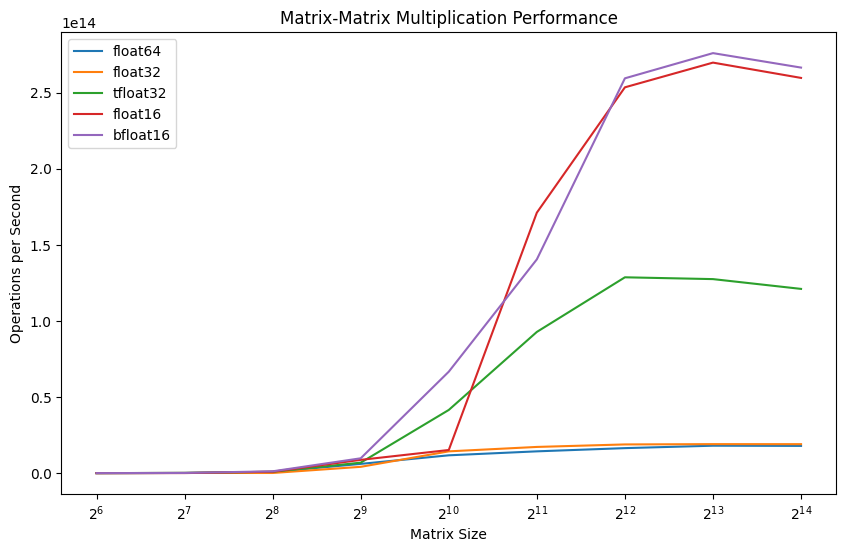

In [8]:
# Matrix Size vs Operations Per Second

# 1. Compare different matrix-matrix multiplication sizes
def compare_matmul_size():
    sizes = [2**i for i in range(6, 15)]
    dtypes = {
        "float64": torch.float64,
        "float32": torch.float32,
        "tfloat32": torch.float32,
        "float16": torch.float16,
        "bfloat16": torch.bfloat16,
    }
    mm_times = {dtype: [] for dtype in dtypes}
    
    for dtype in dtypes:
        for size in sizes:
            matrix1 = torch.randn(size, size, device=device, dtype=dtypes[dtype])
            matrix2 = torch.randn(size, size, device=device, dtype=dtypes[dtype])
            
            if dtype == 'tfloat32':
                # Typically need to allow tfloat32 for matmuls explicitly
                torch.set_float32_matmul_precision('high')
            else:
                # This is default unless you are using an nvidia optimized image
                torch.set_float32_matmul_precision('highest')

            _, mm_time = measure_performance(torch.matmul, matrix1, matrix2)
            mm_times[dtype].append(2 * size**3 / mm_time)  # Operations per second
    
    plt.figure(figsize=(10, 6))
    for dtype in dtypes:
        plt.semilogx(sizes, mm_times[dtype], base=2, label=dtype)
    plt.xlabel('Matrix Size')
    plt.ylabel('Operations per Second')
    plt.title('Matrix-Matrix Multiplication Performance')
    plt.legend()
    plt.show()

compare_matmul_size()


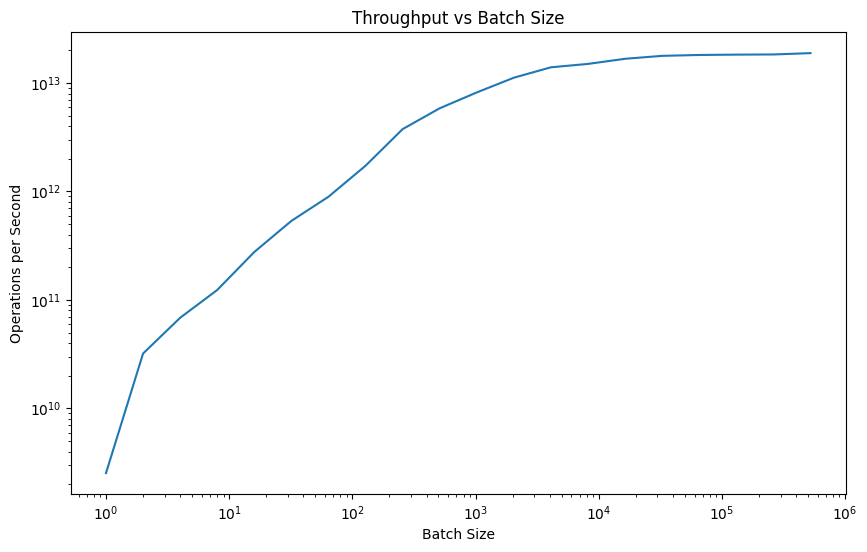

In [9]:
# 2. Different Batch Sizes
def compare_batch_size():
    size = 512
    bsizes = [2**i for i in range(20)]
    mm_times = []
    
    for bsize in bsizes:
        matrix = torch.randn(size, size, device=device)
        batch = torch.randn(size, bsize, device=device)

        _, mm_time = measure_performance(torch.matmul, matrix, batch)
        
        mm_times.append(2 * size**2 * bsize / mm_time)  # Operations per second
    
    plt.figure(figsize=(10, 6))
    plt.loglog(bsizes, mm_times)
    plt.xlabel('Batch Size')
    plt.ylabel('Operations per Second')
    plt.title('Throughput vs Batch Size')
    plt.show()

compare_batch_size()

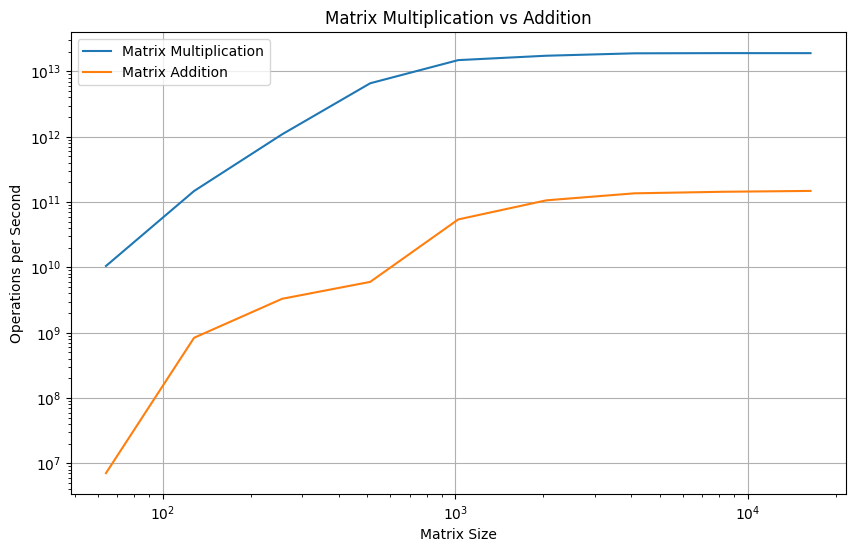

In [10]:
# 3. Compare matrix-matrix multiplication to addition
def compare_mm_add():
    sizes = [2**i for i in range(6, 15)]
    mm_times, add_times = [], []
    
    for size in sizes:
        matrix1 = torch.randn(size, size, device=device)
        matrix2 = torch.randn(size, size, device=device)
        
        _, mm_time = measure_performance(torch.matmul, matrix1, matrix2)
        _, add_time = measure_performance(torch.add, matrix1, matrix2)
        
        mm_times.append(2 * size**3 / mm_time)  # Operations per second
        add_times.append(size**2 / add_time)  # Operations per second
    
    plt.figure(figsize=(10, 6))
    plt.loglog(sizes, mm_times, label='Matrix Multiplication')
    plt.loglog(sizes, add_times, label='Matrix Addition')
    plt.xlabel('Matrix Size')
    plt.ylabel('Operations per Second')
    plt.title('Matrix Multiplication vs Addition')
    plt.legend()
    plt.grid()
    plt.show()

compare_mm_add()

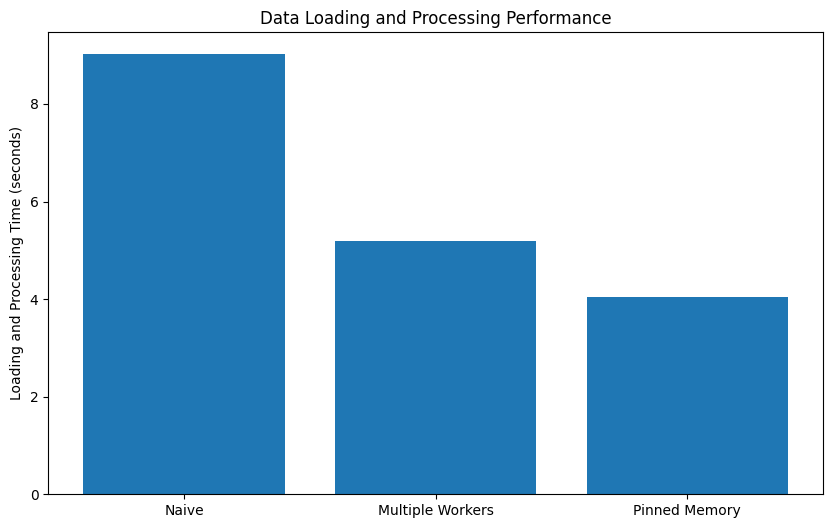

In [11]:
# 4. Efficient data loading demonstration
class DummyDataset(Dataset):
    def __init__(self, size):
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        data = torch.arange(10000).reshape(100, 100).float()
        data = torch.cos(data)
        return data

def process_batch(batch):
    # Simulate some GPU operations
    processed = batch
    for _ in range(10):
        processed = torch.matmul(batch, batch)
        processed = torch.nn.functional.relu(processed)
    loss = processed.sum()
    torch.cuda.synchronize()  # Simulate the synchronization point from the optimizer step
    return loss

def load_and_process_data(dataloader):
    start = time.time()
    total = 0
    for batch in dataloader:
        batch = batch.to(device)
        total += process_batch(batch)
    end = time.time()
    return end - start

def compare_data_loading():
    dataset = DummyDataset(100000)
    
    # Naive loading
    naive_loader = DataLoader(dataset, batch_size=32, num_workers=0)
    naive_time = load_and_process_data(naive_loader)
    
    # Multiple workers
    multi_loader = DataLoader(dataset, batch_size=32, num_workers=4, pin_memory=False)
    multi_time = load_and_process_data(multi_loader)

    # Pinned memory
    pinned_loader = DataLoader(dataset, batch_size=32, num_workers=4, pin_memory=True)
    pinned_time = load_and_process_data(pinned_loader)
    
    # Even this may not be enough, you should measure both the dataloader on its own
    # no GPU compute (disable it) and the GPU compute on its own (e.g. same data)
    # to see where the bottleneck is
    
    plt.figure(figsize=(10, 6))
    plt.bar(['Naive', 'Multiple Workers', 'Pinned Memory'], 
            [naive_time, multi_time, pinned_time])
    plt.ylabel('Loading and Processing Time (seconds)')
    plt.title('Data Loading and Processing Performance')
    plt.show()

# Run all comparisons
compare_data_loading()